# Confidence Intervals

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from bootstrap import *

## Bootstrapped CIs

note: adapted from
https://github.com/XiangwenWang/correlation/blob/master/correlation.py

In [2]:
# Settings for simulated data
n = 1000
corr_val = 0.75
covs = [[1, corr_val], [corr_val, 1]]
means = [0, 0]

# Generate the data
x, y = np.random.multivariate_normal(means, covs, n).T

In [3]:
# Bootstrap settings
corr_func = spearmanr
alpha = 0.05
n_samples = 5000

In [4]:
# Calculate the estimated correlation between the data
r, p = corr_func(x, y)
print(r, p)

0.7456193296193296 3.97003103446083e-178


In [5]:
# Resample bootstraps
bootstrap_x, bootstrap_y = sample_bootstrap(n_samples, x, y)

# Compute estimates across resamples
estimates = compute_bootstrap_estimates(bootstrap_x, bootstrap_y, corr_func)
    
# Compute confidence intervals from bootstrapped distribution
cis = compute_cis(estimates, alpha)

In [6]:
print(cis)

(0.7121693090975091, 0.7743737284157215)


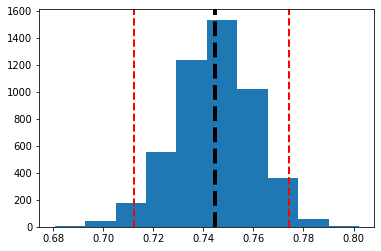

In [7]:
plot_bootstrap(estimates, cis)

### Analytic CI's

Steiger's test.

In [8]:
from pingouin import corr

In [9]:
out = corr(x, y, method='spearman')
out

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,1000,0.745619,"[0.72, 0.77]",0.555948,0.555057,3.970031e-178,1.0


In [10]:
out = corr(x, y, method='pearson')

In [11]:
out['CI95%']

pearson    [0.74, 0.79]
Name: CI95%, dtype: object

## CI's of a difference

Case: test difference in correlation between AB & AC.

In [12]:
# Settings for simulated data
n = 500
means = [0, 0, 0]

corr_ab = 0.25
corr_ac = 0.50
corr_bc = 0.75

covs = [[1, corr_ab, corr_ac], [corr_ab, 1, corr_bc], [corr_ac, corr_bc, 1]]

In [13]:
# Simulate arrays of data with correlations between them
a, b, c = np.random.multivariate_normal(means, covs, n).T

In [14]:
# Calculate corr values between each array
r_ab, p_ab = corr_func(a, b)
r_ac, p_ac = corr_func(a, c)
r_bc, p_bc = corr_func(b, c)

print(r_ab, p_ab)
print(r_ac, p_ac)
print(r_bc, p_bc)

0.15848607394429579 0.0003744077903503296
0.4144700418801675 3.540773937690749e-22
0.7389692918771675 1.87351439243309e-87


In [15]:
# Calculate the difference of correlation of interest
r_diff = r_ab - r_ac
print(r_diff)

-0.25598396793587175


In [16]:
# Sample bootstraps
bootstrap_a, bootstrap_b, bootstrap_c = sample_bootstrap(n_samples, a, b, c)

In [17]:
# Compute estimates
corrs_ab = compute_bootstrap_estimates(bootstrap_a, bootstrap_b, corr_func)
corrs_ac = compute_bootstrap_estimates(bootstrap_a, bootstrap_c, corr_func)

In [18]:
# Calculate diffs
diffs = corrs_ab - corrs_ac

In [19]:
# Calculate the confidence intervals of the difference measure
cis = compute_cis(diffs, alpha)

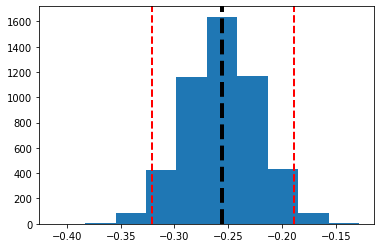

In [20]:
# Plot the distribution of calculated difference estimates
plot_bootstrap(diffs, cis)

In [21]:
# Calculate estimated p-value from differences
test_stat, p_val = compute_pvalue(r_diff, cis)
print(test_stat, p_val)

-7.562372150382188 2.0555938824574993e-13
